# UBA - Aprendizaje por Refuerzo I
## Desafío práctico - Snake + DQN (PyTorch) 

**Objetivo:** entrenar un **DQN con CNN** sobre un entorno **Snake** propio (sin Gym), graficar la **convergencia** (media móvil), y evaluar la política **greedy** aprendida.

> Requisitos:
> ```bash
> pip install torch matplotlib numpy
> ```
> - Corre en **CPU**, **CUDA** o **MPS** (Apple Silicon).  
> - La red usa **Global Average Pool (1×1)** para evitar el error de MPS con tallas no divisibles.


In [2]:

import math, random, time
from collections import deque
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def get_torch_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_torch_device()
device


device(type='mps')

## Entorno Snake

In [4]:
@dataclass
class StepResult:
    obs: np.ndarray
    reward: float
    terminated: bool
    truncated: bool
    info: dict

class SnakeEnv:
    def __init__(self, width: int = 12, height: int = 12, max_steps: int = 300, seed: int = 42):
        self.W, self.H = width, height
        self.max_steps = max_steps
        self.rng = np.random.default_rng(seed)
        self.actions = 4  # 0:←, 1:↓, 2:→, 3:↑
        self.reset()

    def reset(self):
        self.dir = 2  # derecha
        midr, midc = self.H // 2, self.W // 2
        self.snake: deque = deque([(midr, midc-1), (midr, midc), (midr, midc+1)])
        self._place_food()
        self.steps = 0
        self.done = False
        self.score = 0
        return self._obs()

    def _place_food(self):
        free = [(r, c) for r in range(self.H) for c in range(self.W) if (r, c) not in self.snake]
        self.food = free[self.rng.integers(len(free))] if free else None

    def _obs(self) -> np.ndarray:
        head = np.zeros((self.H, self.W), dtype=np.float32)
        body = np.zeros((self.H, self.W), dtype=np.float32)
        food = np.zeros((self.H, self.W), dtype=np.float32)
        hr, hc = self.snake[-1]
        head[hr, hc] = 1.0
        for (r, c) in list(self.snake)[:-1]:
            body[r, c] = 1.0
        if self.food is not None:
            fr, fc = self.food
            food[fr, fc] = 1.0
        return np.stack([head, body, food], axis=0)

    def step(self, action: int) -> StepResult:
        if self.done:
            raise RuntimeError("Episodio terminado; usa reset().")
        self.steps += 1
        self.dir = int(action)
        drc = {0:(0,-1), 1:(1,0), 2:(0,1), 3:(-1,0)}
        dr, dc = drc[self.dir]
        hr, hc = self.snake[-1]
        nr, nc = hr + dr, hc + dc

        reward = -0.01
        terminated = False
        truncated = False

        if not (0 <= nr < self.H and 0 <= nc < self.W):
            reward = -1.0
            terminated = True
        else:
            if (nr, nc) in self.snake:
                reward = -1.0
                terminated = True
            else:
                self.snake.append((nr, nc))
                if self.food is not None and (nr, nc) == self.food:
                    reward = +1.0
                    self.score += 1
                    self._place_food()
                else:
                    self.snake.popleft()

        if self.steps >= self.max_steps and not terminated:
            truncated = True

        self.done = terminated or truncated
        return StepResult(self._obs(), reward, terminated, truncated, {"score": self.score})


## DQN con CNN

In [5]:

class DQNCNN(nn.Module):
    def __init__(self, in_channels: int, n_actions: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # Global AvgPool: robusto en MPS
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 256), nn.ReLU(),
            nn.Linear(256, n_actions)
        )
    def forward(self, x):
        x = self.features(x)
        return self.head(x)

class ReplayBuffer:
    def __init__(self, capacity: int, obs_shape: Tuple[int,int,int]):
        self.capacity = capacity
        C,H,W = obs_shape
        self.s = np.zeros((capacity, C, H, W), dtype=np.float32)
        self.a = np.zeros((capacity,), dtype=np.int64)
        self.r = np.zeros((capacity,), dtype=np.float32)
        self.ns = np.zeros((capacity, C, H, W), dtype=np.float32)
        self.d = np.zeros((capacity,), dtype=np.bool_)
        self.idx = 0
        self.full = False

    def push(self, s, a, r, ns, done):
        self.s[self.idx] = s
        self.a[self.idx] = a
        self.r[self.idx] = r
        self.ns[self.idx] = ns
        self.d[self.idx] = done
        self.idx = (self.idx + 1) % self.capacity
        if self.idx == 0: self.full = True

    def __len__(self):
        return self.capacity if self.full else self.idx

    def sample(self, batch_size: int):
        N = len(self)
        idxs = np.random.randint(0, N, size=batch_size)
        return ( self.s[idxs], self.a[idxs], self.r[idxs], self.ns[idxs], self.d[idxs] )

def moving_average(x: List[float], w: int = 50):
    if len(x) < 2: return np.array(x, dtype=float)
    if len(x) < w: w = max(1, len(x)//2)
    return np.convolve(np.array(x, dtype=float), np.ones(w)/w, mode="valid")


## Entrenamiento DQN

In [6]:

def train_dqn(
    episodes=600, grid_size=12, max_steps=300,
    gamma=0.99, lr=1e-3,
    batch_size=64, buffer_size=50_000, start_learn=1_000,
    target_update_freq=1_000, eps_start=1.0, eps_end=0.05, eps_decay=0.995,
    seed=42, device=None, verbose=True
):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else (torch.device("mps") if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else torch.device("cpu")))
    env = SnakeEnv(grid_size, grid_size, max_steps, seed)
    obs = env.reset()
    C,H,W = obs.shape
    nA = env.actions

    policy_net = DQNCNN(C, nA).to(device)
    target_net = DQNCNN(C, nA).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(buffer_size, (C,H,W))

    eps = eps_start
    step_count = 0
    returns = []

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    for ep in range(episodes):
        s = env.reset()
        ep_ret = 0.0
        for t in range(max_steps):
            step_count += 1
            # epsilon-greedy
            if np.random.rand() < eps:
                a = np.random.randint(nA)
            else:
                with torch.no_grad():
                    ts = torch.from_numpy(s).unsqueeze(0).to(device)  # (1,C,H,W)
                    q = policy_net(ts)
                    a = int(torch.argmax(q, dim=1).item())

            res = env.step(a)
            ns, r = res.obs, res.reward
            done = res.terminated or res.truncated

            buffer.push(s, a, r, ns, done)
            ep_ret += r
            s = ns

            # learn
            if len(buffer) >= start_learn:
                bs, ba, br, bns, bd = buffer.sample(batch_size)
                bs = torch.from_numpy(bs).to(device)
                ba = torch.from_numpy(ba).to(device)
                br = torch.from_numpy(br).to(device)
                bns = torch.from_numpy(bns).to(device)
                bd = torch.from_numpy(bd.astype(np.float32)).to(device)

                # Q(s,a)
                qsa = policy_net(bs).gather(1, ba.view(-1,1)).squeeze(1)
                with torch.no_grad():
                    max_next = target_net(bns).max(1)[0]
                    target = br + gamma * (1.0 - bd) * max_next
                loss = nn.SmoothL1Loss()(qsa, target)

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
                optimizer.step()

                # target update
                if step_count % target_update_freq == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        # epsilon decay por episodio
        eps = max(eps_end, eps * eps_decay)
        returns.append(ep_ret)

        if verbose and ((ep+1) % max(1, episodes//10) == 0):
            ma = moving_average(returns, 50)
            msg = f"[Ep {ep+1:4d}] Return: {ep_ret:6.2f} | eps={eps:.3f}"
            if len(ma) > 0:
                msg += f" | MA50={ma[-1]:.2f}"
            print(msg)

    return policy_net, returns, env


### Ejecutar entrenamiento

In [7]:

policy, returns, env = train_dqn(
    episodes=800,     
    grid_size=12,
    max_steps=300,
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    buffer_size=50_000,
    start_learn=1_000,
    target_update_freq=1_000,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995,
    seed=42,
    device=device,
    verbose=True
)
len(returns), returns[:5]


/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Ep   80] Return:  -1.08 | eps=0.670 | MA50=-0.99
[Ep  160] Return:  -1.01 | eps=0.448 | MA50=-1.03
[Ep  240] Return:  -1.06 | eps=0.300 | MA50=-1.02
[Ep  320] Return:  -1.08 | eps=0.201 | MA50=-0.90
[Ep  400] Return:  -0.21 | eps=0.135 | MA50=-0.65
[Ep  480] Return:   3.81 | eps=0.090 | MA50=-0.32
[Ep  560] Return:   0.91 | eps=0.060 | MA50=0.64
[Ep  640] Return:  -0.06 | eps=0.050 | MA50=3.83
[Ep  720] Return:   6.31 | eps=0.050 | MA50=3.15
[Ep  800] Return:  -1.00 | eps=0.050 | MA50=3.41


(800, [-1.0, -1.05, -1.01, -1.04, -1.08])

### Gráfico de convergencia (MA=50)

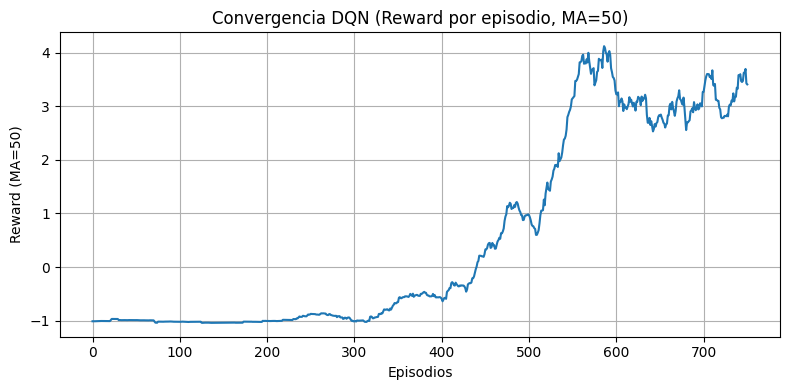

In [8]:

plt.figure(figsize=(8,4))
ma = moving_average(returns, 50)
plt.plot(ma)
plt.title("Convergencia DQN (Reward por episodio, MA=50)")
plt.xlabel("Episodios"); plt.ylabel("Reward (MA=50)"); plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluación greedy (ε=0)

In [9]:

def evaluate_greedy(policy_net, episodes=100, grid_size=12, max_steps=300, seed=123):
    env = SnakeEnv(grid_size, grid_size, max_steps, seed)
    policy_net.eval()
    total = 0.0
    foods = 0
    for ep in range(episodes):
        s = env.reset()
        ep_ret = 0.0
        while True:
            with torch.no_grad():
                ts = torch.from_numpy(s).unsqueeze(0).to(next(policy_net.parameters()).device)
                q = policy_net(ts)
                a = int(torch.argmax(q, dim=1).item())
            res = env.step(a)
            s = res.obs
            ep_ret += res.reward
            if res.reward > 0: foods += 1
            if res.terminated or res.truncated: break
        total += ep_ret
    return total/episodes, foods/episodes

avg_ret, avg_food = evaluate_greedy(policy, episodes=100, grid_size=12, max_steps=300)
avg_ret, avg_food


(15.251899999999962, 18.11)

### Guardar / Cargar pesos

In [ ]:

WEIGHTS_PATH = "snake_dqn_weights.pth"
torch.save(policy.state_dict(), WEIGHTS_PATH)
print("Pesos guardados en", WEIGHTS_PATH)

Pesos guardados en snake_dqn_weights.pth


In [11]:
# Ejemplo de carga:
model = DQNCNN(3, 4).to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
model.eval()


DQNCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
)